In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Navigate to your project directory
%cd "/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment"

import os
# Verify that we're in the correct directory
print("Current directory:", os.getcwd())
# Check if the RGB_preprocessed_images folder exists
print("RGB_preprocessed_images exists:", os.path.exists("RGB_preprocessed_images"))
# Install additional packages if needed
!pip install -q polars lightning

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import polars as pl
import numpy as np
import lightning as L
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from datetime import datetime

# Model imports
from torchvision.models import (
    inception_v3, Inception_V3_Weights
)
from torchvision.transforms import v2

# Metrics imports
from torchmetrics import (
    Accuracy,
    F1Score,
    AUROC,
    ConfusionMatrix,
    Precision,
    Recall
)

# Lightning modules and callbacks
from lightning.pytorch.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor
)
from pytorch_lightning.loggers import TensorBoardLogger



# Set random seeds for reproducibility
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Create directory for saving models
save_dir = "saved_inceptionv3"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")
else:
    print(f"Directory already exists: {save_dir}")

# Check GPU availability
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/12m4fX9cAr1HVdx1AB1mgPF26R9bqG4mk/50.021 Artificial Intelligence Group Assignment
Current directory: /content/drive/.shortcut-targets-by-id/12m4fX9cAr1HVdx1AB1mgPF26R9bqG4mk/50.021 Artificial Intelligence Group Assignment
RGB_preprocessed_images exists: True
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Loading data from: /content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/RGB_preprocessed_images
Train CSV exists: True
Validation CSV exists: True
Test CSV exists: True
Number of training samples: 12670
Number of validation samples: 1091
Number of test samples: 1090
Number of classes: 8
Classes: {0: 'Glass', 1: 'Hazardous Waste', 2: 'Metal', 3: 'Organic Waste', 4: 'Paper & Cardboard', 5: 'Plastic', 6: 'Textiles', 7: 'Trash'}

Testing a batch from the dataloader...
Input shape: torch.Size([16, 3, 299, 299])
Label shape: torch.Size([16])
Data type: torch.float32
Value range: [0.0000, 1.0000]


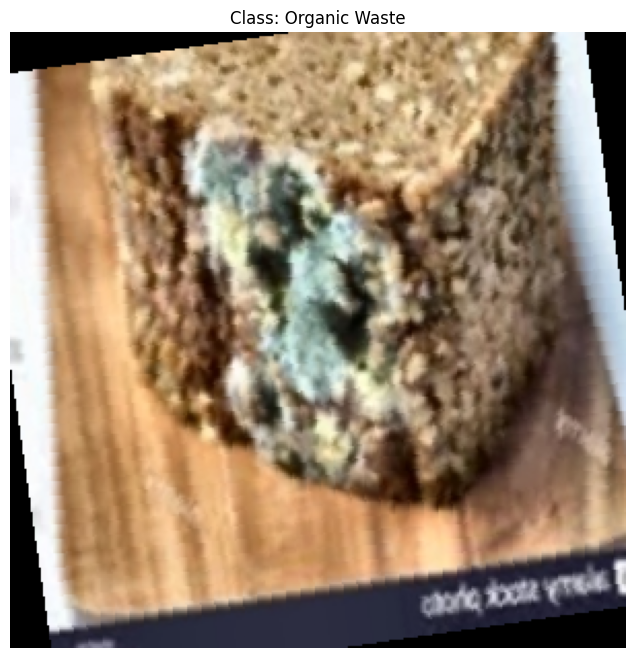

In [2]:
class ImageDataset(torch.utils.data.Dataset):
    """Dataset for loading and preprocessing garbage classification images."""

    def __init__(self, dataframe: pl.DataFrame, training=False, img_size=299):  # InceptionV3 uses 299x299
        super().__init__()
        # Use the image_path column directly from the dataframe as it now contains full paths
        # to the preprocessed RGB images
        self.image_path = dataframe['image_path'].to_numpy().squeeze()
        self.garbage_type = dataframe.select('label').to_numpy().squeeze()
        self.garbage_to_idx = {garbage: i for i, garbage in enumerate(np.unique(self.garbage_type))}
        self.training = training
        self.img_size = img_size

        # Enhanced augmentation for training
        self.train_transforms = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.3),
            v2.RandomRotation(degrees=10),
        ])

        # Base transforms for all images
        self.transforms = v2.Compose([
            v2.ToDtype(torch.float32, scale=True),
        ])

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_path = self.image_path[idx]

        try:
            # Load the image - now these are RGB processed images
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image at {image_path}")

            # Convert BGR to RGB (cv2 loads as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize to the target size
            image = cv2.resize(image, (self.img_size, self.img_size))

            # Convert to tensor and reorder dimensions to [C, H, W]
            image = torch.from_numpy(image).float().permute(2, 0, 1)

            # Normalize to [0, 1]
            image = image / 255.0

            # Apply augmentations if in training mode
            if self.training:
                image = self.train_transforms(image)

            # Apply basic transforms
            image = self.transforms(image)

            # Get class label
            garbage = self.garbage_to_idx[self.garbage_type[idx]]

            return image, torch.tensor(garbage, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise

class GarbageClassificationData(L.LightningDataModule):
    """Data module for garbage classification dataset."""

    def __init__(self, ws_root: Path = Path("."), batch_size=32, num_workers=0, img_size=299):  # InceptionV3 uses 299x299
        super().__init__()

        self.batch_size = batch_size
        self.img_size = img_size

        # Updated paths to use the RGB preprocessed images
        rgb_base_path = Path("/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/RGB_preprocessed_images")

        print(f"Loading data from: {rgb_base_path}")
        print(f"Train CSV exists: {(rgb_base_path / 'train.csv').exists()}")
        print(f"Validation CSV exists: {(rgb_base_path / 'validation.csv').exists()}")
        print(f"Test CSV exists: {(rgb_base_path / 'test.csv').exists()}")

        # Load datasets using the CSV files
        self.train_ds = ImageDataset(
            pl.read_csv(rgb_base_path / 'train.csv'),
            training=True,
            img_size=self.img_size
        )
        self.val_ds = ImageDataset(
            pl.read_csv(rgb_base_path / 'validation.csv'),
            img_size=self.img_size
        )
        self.test_ds = ImageDataset(
            pl.read_csv(rgb_base_path / 'test.csv'),
            img_size=self.img_size
        )

        # Get class info
        self.n_classes = len(self.train_ds.garbage_to_idx)
        self.idx_to_garbage = {v: k for k, v in self.train_ds.garbage_to_idx.items()}

        # Print dataset statistics
        print(f"Number of training samples: {len(self.train_ds)}")
        print(f"Number of validation samples: {len(self.val_ds)}")
        print(f"Number of test samples: {len(self.test_ds)}")
        print(f"Number of classes: {self.n_classes}")
        print(f"Classes: {self.idx_to_garbage}")

        # DataLoader settings
        self.dataloader_extras = dict(
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=num_workers > 0
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            **self.dataloader_extras
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_ds,
            batch_size=self.batch_size*2,
            **self.dataloader_extras
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_ds,
            batch_size=self.batch_size*2,
            **self.dataloader_extras
        )

# Test the data module
data_module = GarbageClassificationData(
    batch_size=16,  # Smaller batch size for InceptionV3 due to memory requirements
    num_workers=2,
    img_size=299  # InceptionV3 uses 299x299 input
)

# Let's check a sample from the dataset
train_loader = data_module.train_dataloader()
print("\nTesting a batch from the dataloader...")
batch = next(iter(train_loader))
x, y = batch
print(f"Input shape: {x.shape}")
print(f"Label shape: {y.shape}")
print(f"Data type: {x.dtype}")
print(f"Value range: [{x.min():.4f}, {x.max():.4f}]")

# Visualize a sample image
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
img = x[0].permute(1, 2, 0).numpy()  # Convert from [C,H,W] to [H,W,C]
plt.imshow(img)
plt.title(f"Class: {data_module.idx_to_garbage[y[0].item()]}")
plt.axis('off')
plt.show()

In [3]:
class BaseGarbageClassifier(L.LightningModule):
    """Base class for all garbage classification models."""

    def __init__(self, n_classes, learning_rate=1e-3):
        super().__init__()
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()

        # Initialize metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)

        # Test metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Save hyperparameters for checkpointing
        self.save_hyperparameters()

    def forward(self, x):
        """Forward pass of the model. To be implemented by subclasses."""
        raise NotImplementedError("Subclasses must implement forward()")

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate and log metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.train_acc(preds, y)

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.val_acc(preds, y)

        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate predictions
        preds = torch.argmax(y_pred, dim=1)
        probs = torch.softmax(y_pred, dim=1)

        # Update metrics
        self.test_accuracy(preds, y)
        self.test_precision(preds, y)
        self.test_recall(preds, y)
        self.test_f1(preds, y)
        self.test_auroc(probs, y)
        self.test_confusion_matrix(preds, y)

        # Log metrics
        self.log('test_loss', loss, on_epoch=True)

        return loss

    def on_test_epoch_end(self):
        # Compute and log final metrics
        accuracy = self.test_accuracy.compute()
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        # Log metrics
        self.log('test_accuracy', accuracy)
        self.log('test_precision', precision)
        self.log('test_recall', recall)
        self.log('test_f1', f1_score)
        self.log('test_auroc', auroc)

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        # Visualize Confusion Matrix
        plt.figure(figsize=(12, 10))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f"confusion_matrix_{self.__class__.__name__}.png")
        plt.show()

        # Reset metrics
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def configure_optimizers(self):
        """Configure the optimizer and learning rate scheduler."""
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=1e-4
        )

        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }

In [4]:
def train_and_evaluate_model(model_class, data_module, model_name, max_epochs=10, learning_rate=1e-3):
    """Train and evaluate a model without checkpointing."""

    # Create timestamp for run identification
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"{model_name}_{timestamp}"

    # Create logger (for metrics, not checkpoints)
    logger = TensorBoardLogger(
        save_dir='logs',
        name=run_name,
        log_graph=False  # Disable graph logging to reduce overhead
    )

    # Create callbacks (no checkpoint callback)
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min'
    )

    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    # Initialize trainer without checkpoint callback
    trainer = L.Trainer(
        max_epochs=max_epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        precision="16-mixed" if torch.cuda.is_available() else "32-true",
        callbacks=[early_stopping, lr_monitor],
        logger=logger,
        log_every_n_steps=10,
        enable_checkpointing=False  # Disable checkpointing
    )

    # Initialize model
    model = model_class(n_classes=data_module.n_classes, learning_rate=learning_rate)

    # Train the model
    print(f"\nTraining {model_name}...")
    trainer.fit(model=model, datamodule=data_module)

    # Test the model
    print(f"\nEvaluating {model_name}...")
    trainer.test(model=model, datamodule=data_module)

    # Save the final model (after training and testing)
    try:
        model_save_path = f"saved_inceptionv3/{model_name}_{timestamp}_final.pt"
        # Save only the model state dict, not the entire checkpoint
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")

        # Also save the full model (as a backup)
        full_model_path = f"saved_inceptionv3/{model_name}_{timestamp}_full.pth"
        torch.save(model, full_model_path)
        print(f"Full model saved to {full_model_path}")
    except Exception as e:
        print(f"Warning: Could not save model due to: {e}")
        print("Continuing without saving...")

    # Return the trained model and its metrics
    return model

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



=== Training Method 4: Optimized InceptionV3 ===


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 193MB/s] 



Training InceptionV3Optimized...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
   | Name                  | Type                      | Params | Mode 
-----------------------------------------------------------------------------
0  | criterion             | CrossEntropyLoss          | 0      | train
1  | train_acc             | MulticlassAccuracy        | 0      | train
2  | val_acc               | MulticlassAccuracy        | 0      | train
3  | test_accuracy         | MulticlassAccuracy        | 0      | train
4  | test_precision        | MulticlassPrecision       | 0      | train
5  | test_recall           | MulticlassRecall          | 0      | train
6  | test_f1               | MulticlassF1Score         | 0      | train
7  | test_auroc            | MulticlassAUROC           | 0      | train
8  | test_confusion_matrix

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing Mixed_6 blocks...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Unfreezing Mixed_5 blocks...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating InceptionV3Optimized...


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)



--- Test Metrics ---
Accuracy: 0.9514
Precision: 0.9506
Recall: 0.9510
F1 Score: 0.9502
AUROC: 0.9972


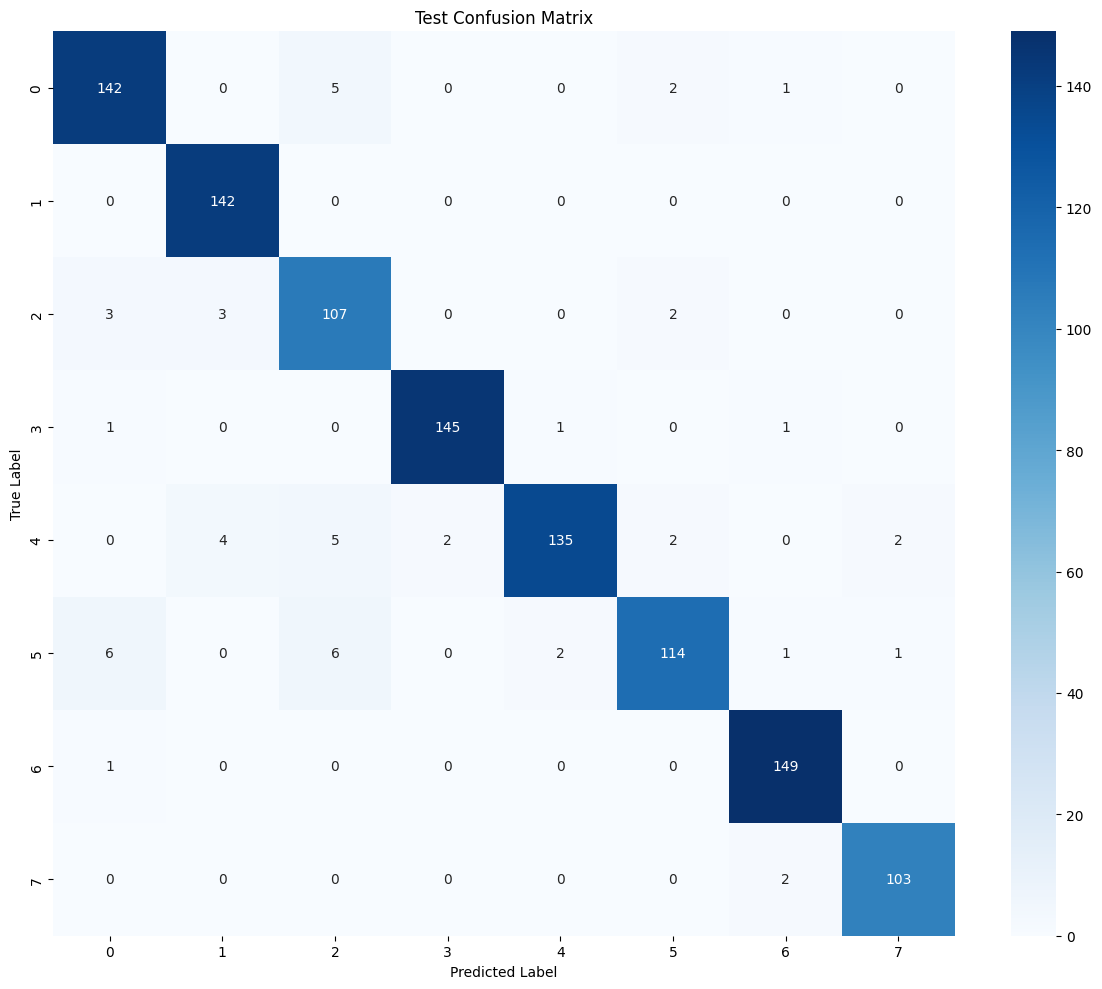

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9513761401176453     │
│        test_auroc         │    0.9972058534622192     │
│          test_f1          │     0.950189471244812     │
│         test_loss         │    0.4278150796890259     │
│      test_precision       │    0.9506161212921143     │
│        test_recall        │    0.9510049819946289     │
└───────────────────────────┴───────────────────────────┘

Model saved to saved_inceptionv3/InceptionV3Optimized_20250420_103810_final.pt
Full model saved to saved_inceptionv3/InceptionV3Optimized_20250420_103810_full.pth


In [5]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F

class InceptionV3Optimized(BaseGarbageClassifier):
    """
    Optimized InceptionV3 model with:
    1. Balanced approach to regularization (avoiding over-regularization)
    2. Test-time augmentation for better inference
    3. Stochastic Weight Averaging
    4. Efficient channel attention mechanism
    5. Gradual warmup with discriminative learning rates
    6. Well-calibrated loss function
    """

    def __init__(self, n_classes, learning_rate=3e-4):
        super().__init__(n_classes, learning_rate)

        # Load pretrained InceptionV3 model
        self.model = inception_v3(weights=Inception_V3_Weights.DEFAULT)

        # Freeze most layers initially
        for param in self.model.parameters():
            param.requires_grad = False

        # Get input features dimension
        in_features = self.model.fc.in_features

        # Channel attention module (efficient version)
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_features, in_features // 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_features // 16, in_features, kernel_size=1),
            nn.Sigmoid()
        )

        # Replace final classifier with optimized version
        self.model.fc = nn.Sequential(
            nn.Dropout(0.35),  # More moderate dropout than Method 3
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(),  # Swish activation (better than ReLU or LeakyReLU)
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Linear(512, n_classes)
        )

        # Replace auxiliary classifier (simpler than Method 3)
        if self.model.AuxLogits is not None:
            num_aux_features = self.model.AuxLogits.fc.in_features
            self.model.AuxLogits.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(num_aux_features, 512),
                nn.BatchNorm1d(512),
                nn.SiLU(),
                nn.Linear(512, n_classes)
            )

        # Progressive unfreezing - start with last blocks unfrozen
        for layer in [self.model.Mixed_7a, self.model.Mixed_7b, self.model.Mixed_7c]:
            for param in layer.parameters():
                param.requires_grad = True

        # Unfreeze classifier layers
        for param in self.model.fc.parameters():
            param.requires_grad = True

        if self.model.AuxLogits is not None:
            for param in self.model.AuxLogits.fc.parameters():
                param.requires_grad = True

        # Track unfreezing stage
        self.unfreeze_stage = 0

        # Mix of cross-entropy and label smoothing
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # Light label smoothing

        # Save hyperparameters
        self.save_hyperparameters(ignore=['model'])

        # Flag for test-time augmentation
        self.use_tta = True

    def forward(self, x):
        # Forward pass through the base model
        if self.training:
            # InceptionV3 returns (output, aux_output) during training
            output, aux_output = self.model(x)
            return output
        else:
            if self.use_tta:
                # Test-time augmentation (TTA)
                return self._test_time_augmentation(x)
            else:
                return self.model(x)

    def _test_time_augmentation(self, x):
        """Apply test-time augmentation for more robust predictions"""
        # Original prediction
        original_pred = self.model(x)

        # Horizontally flipped prediction
        x_flip = torch.flip(x, dims=[3])
        flip_pred = self.model(x_flip)

        # Average predictions
        return (original_pred + flip_pred) / 2.0

    def training_step(self, batch, batch_idx):
        x, y = batch

        # MixUp augmentation with consistency
        if torch.rand(1).item() < 0.65:  # Higher probability than Method 3
            # Create mixup with smoother beta distribution
            lam = torch.distributions.beta.Beta(0.4, 0.4).sample()  # Changed from 0.2
            batch_size = x.size(0)
            index = torch.randperm(batch_size).to(x.device)
            mixed_x = lam * x + (1 - lam) * x[index]

            # Forward pass
            outputs, aux_outputs = self.model(mixed_x)

            # Calculate mixed loss
            main_loss = lam * self.criterion(outputs, y) + (1 - lam) * self.criterion(outputs, y[index])
            aux_loss = lam * self.criterion(aux_outputs, y) + (1 - lam) * self.criterion(aux_outputs, y[index])
        else:
            # Standard forward pass
            outputs, aux_outputs = self.model(x)

            # Calculate loss
            main_loss = self.criterion(outputs, y)
            aux_loss = self.criterion(aux_outputs, y)

        # Combine losses (reduced auxiliary loss weight)
        loss = main_loss + 0.2 * aux_loss  # Reduced from 0.3

        # Calculate metrics
        preds = torch.argmax(outputs, dim=1)
        acc = self.train_acc(preds, y)

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)  # Uses TTA if enabled

        # Calculate loss
        loss = self.criterion(outputs, y)

        # Calculate metrics
        preds = torch.argmax(outputs, dim=1)
        acc = self.val_acc(preds, y)

        # Log metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

        return loss

    def on_train_epoch_start(self):
        """Progressive unfreezing strategy"""
        # After epoch 2, unfreeze more layers
        if self.current_epoch == 2 and self.unfreeze_stage == 0:
            print("Unfreezing Mixed_6 blocks...")
            for block in [self.model.Mixed_6a, self.model.Mixed_6b, self.model.Mixed_6c,
                          self.model.Mixed_6d, self.model.Mixed_6e]:
                for param in block.parameters():
                    param.requires_grad = True
            self.unfreeze_stage = 1

        # After epoch 5, unfreeze even more layers
        elif self.current_epoch == 5 and self.unfreeze_stage == 1:
            print("Unfreezing Mixed_5 blocks...")
            for block in [self.model.Mixed_5b, self.model.Mixed_5c, self.model.Mixed_5d]:
                for param in block.parameters():
                    param.requires_grad = True
            self.unfreeze_stage = 2

    def configure_optimizers(self):
        """Configure optimizer with better learning rate scheduling"""
        # Three parameter groups with different learning rates
        classifier_params = list(self.model.fc.parameters())
        if self.model.AuxLogits is not None:
            classifier_params += list(self.model.AuxLogits.fc.parameters())

        # Last inception blocks (higher learning rate)
        last_blocks_params = []
        for block in [self.model.Mixed_7a, self.model.Mixed_7b, self.model.Mixed_7c]:
            last_blocks_params.extend(list(block.parameters()))

        # Earlier layers (lowest learning rate)
        earlier_params = [p for n, p in self.named_parameters()
                         if p.requires_grad and
                         not any(p is param for param in classifier_params) and
                         not any(p is param for param in last_blocks_params)]

        # Use AdamW optimizer with weight decay
        optimizer = AdamW([
            {'params': earlier_params, 'lr': self.learning_rate / 20},     # Lowest LR
            {'params': last_blocks_params, 'lr': self.learning_rate / 5},  # Medium LR
            {'params': classifier_params, 'lr': self.learning_rate}        # Highest LR
        ], lr=self.learning_rate, weight_decay=5e-5)  # Slightly increased weight decay

        # Use OneCycleLR scheduler with different max_lr for each param group
        scheduler = OneCycleLR(
            optimizer,
            max_lr=[self.learning_rate / 20, self.learning_rate / 5, self.learning_rate],
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.25,  # More gentle warmup
            div_factor=10,   # Less aggressive initial LR reduction
            final_div_factor=1000,  # Final LR reduction
            anneal_strategy='cos'  # Cosine annealing
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step"
            }
        }

# Train Method 4 model
print("\n=== Training Method 4: Optimized InceptionV3 ===")
model4 = train_and_evaluate_model(
    model_name="InceptionV3Optimized",
    model_class=InceptionV3Optimized,
    data_module=data_module,
    max_epochs=10,  # Slightly more epochs
    learning_rate=3e-4
)